In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as snb

import sqlalchemy
from sqlalchemy.sql import func
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

from flask import Flask, jsonify
from flask import abort
from flask_sqlalchemy import SQLAlchemy

##Create and connect sqlite database

In [2]:
engine = create_engine("sqlite:///hawaii.sqlite", echo=False)

In [3]:
inspector = inspect(engine)
inspector.get_table_names()

['hawaii_measurements', 'hawaii_stations']

In [4]:
columns = inspector.get_columns('hawaii_measurements')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station VARCHAR
date VARCHAR
prcp FLOAT
tobs INTEGER


In [5]:
columns = inspector.get_columns('hawaii_stations')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station VARCHAR
name VARCHAR
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [6]:
engine.execute('SELECT * FROM hawaii_measurements LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65),
 (2, 'USC00519397', '2010-01-02', 0.0, 63),
 (3, 'USC00519397', '2010-01-03', 0.0, 74),
 (4, 'USC00519397', '2010-01-04', 0.0, 76),
 (5, 'USC00519397', '2010-01-07', 0.06, 70)]

In [7]:
engine.execute('SELECT * FROM hawaii_stations LIMIT 5').fetchall()

[(1, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4),
 (5, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)]

In [8]:
Base = automap_base()
Base.prepare(engine, reflect=True)
Measurement = Base.classes.hawaii_measurements
Measurement

sqlalchemy.ext.automap.hawaii_measurements

In [9]:
Base = automap_base()
Base.prepare(engine, reflect=True)
Station = Base.classes.hawaii_stations
Station

sqlalchemy.ext.automap.hawaii_stations

In [10]:
session = Session(engine)

#Query to retrieve the last 12 months of precipitation data

In [11]:
prcp_results = session.query(Measurement.date, Measurement.prcp)\
.filter(Measurement.date.between('2016-08-23','2017-08-23')).order_by(Measurement.date.asc()).all()
prcp_results[:5]

[('2016-08-23', 0.0),
 ('2016-08-23', 0.15),
 ('2016-08-23', 0.05),
 ('2016-08-23', 0.02),
 ('2016-08-23', 1.79)]

In [12]:
date = [row[0] for row in prcp_results]
precipitation = [row[1] for row in prcp_results]

In [13]:
prcp_df = pd.DataFrame(prcp_results, columns=['date', 'precipitation'])
prcp_df.set_index('date', inplace=True)
prcp_df.head(10)

,precipitation
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,0.02
2016-08-23,1.79
2016-08-23,0.70
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28


In [14]:
prcp_df.tail(10)

,precipitation
date,
2017-08-21,0.00
2017-08-21,0.02
2017-08-21,0.56
2017-08-22,0.00
2017-08-22,0.00
2017-08-22,0.50
2017-08-23,0.00
2017-08-23,0.00
2017-08-23,0.08


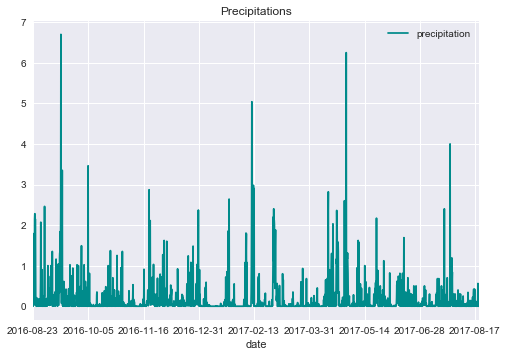

In [15]:
prcp_df.plot(title='Precipitations',color='darkcyan')
plt.show()

##Printing summary

In [16]:
prcp_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


#Calculate the total number of stations

In [17]:
total_stations = session.query(func.count(Station.name)).scalar()
total_stations

9

#Query to list stations and observation counts in descending order

In [18]:
stations_tobs = session.query(Measurement.station, func.count(Measurement.tobs).label('count'))\
.group_by(Measurement.station).order_by('count DESC').all()
stations_tobs

C:\Users\T1L7\AppData\Local\Continuum\Anaconda3\lib\site-packages\sqlalchemy\sql\compiler.py:624: SAWarning: Can't resolve label reference 'count DESC'; converting to text() (this warning may be suppressed after 10 occurrences)
  util.ellipses_string(element.element))


[('USC00519281', 2772),
 ('USC00513117', 2696),
 ('USC00519397', 2685),
 ('USC00519523', 2572),
 ('USC00516128', 2484),
 ('USC00514830', 1937),
 ('USC00511918', 1932),
 ('USC00517948', 683),
 ('USC00518838', 342)]

#Query to retrieve the last 12 months of temperature observation data (tobs)

In [19]:
tobs_results = session.query(Measurement.station, Measurement.tobs)\
.filter(Measurement.date.between('2016-08-23','2017-08-23'),Measurement.station=='USC00519281').all()
tobs_results[:10]

[('USC00519281', 77),
 ('USC00519281', 77),
 ('USC00519281', 80),
 ('USC00519281', 80),
 ('USC00519281', 75),
 ('USC00519281', 73),
 ('USC00519281', 78),
 ('USC00519281', 77),
 ('USC00519281', 78),
 ('USC00519281', 80)]

In [20]:
station = [row[0] for row in tobs_results]
tobs = [row[1] for row in tobs_results]

In [21]:
tobs_df = pd.DataFrame(tobs_results, columns=['stations','tobs'])
tobs_df.set_index('stations', inplace=True)
tobs_df.head(10)

,tobs
stations,
USC00519281,77
USC00519281,77
USC00519281,80
USC00519281,80
USC00519281,75
USC00519281,73
USC00519281,78
USC00519281,77
USC00519281,78


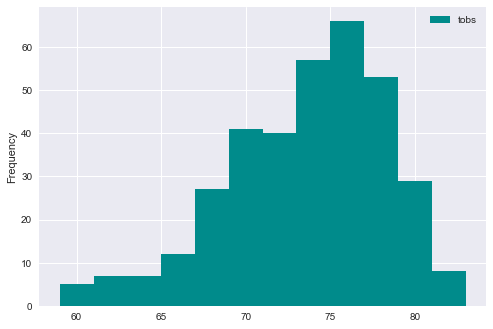

In [22]:
tobs_df.plot.hist(bins=12,color='darkcyan')
plt.show()

##Defining function to calculate temperature (max, min, avg) from a date range.

In [24]:
def calc_temps (start_date, end_date):
    return session.query(func.max(Measurement.tobs).label("max"),\
                         func.min(Measurement.tobs).label("min"),\
                         func.avg(Measurement.tobs).label("avg"))\
                        .filter(Measurement.date>=start_date)\
                        .filter(Measurement.date<=end_date)\
                        .all()

In [25]:
trip_temp =(calc_temps('2017-02-15','2017-03-05'))
trip_temp

[(78, 61, 70.7378640776699)]

In [26]:
trip_max = trip_temp[0][0]
trip_min = trip_temp[0][1]
trip_avg = trip_temp[0][2]
y_error = trip_max - trip_min

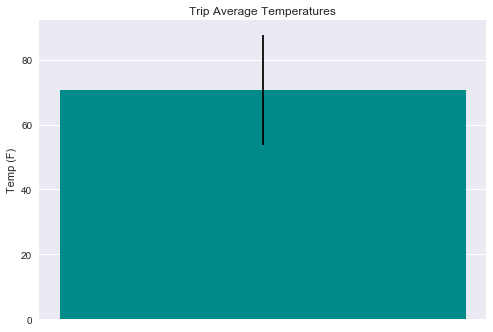

In [34]:
plt.bar(1, trip_avg, color='darkcyan', yerr=y_error)
plt.ylabel(('Temp (F)'))
plt.xticks([]*0)
plt.title(('Trip Average Temperatures'))
plt.show()

In [ ]:
app = Flask(__name__)

@app.route("/")

def home():
    return(
        f"Available Routes:<br/>"
        f"/api/v1.0/precipitation<br>"
        f"/api/v1.0/stations<br>"
        f"/api/v1.0/tobs<br>"
        f"/api/v1.0/<start><br>"
        f"/api/v1.0/<start>/<end>"
    )

@app.route("/api/v1.0/precipitation")

def prcp():
    
    prcp_flask = session.query(Measurement.date, Measurement.prcp)\
    .filter(Measurement.date.between('2016-08-23','2017-08-23')).order_by(Measurement.date.asc()).all()
    
    prcp_key = [row[0] for row in prcp_flask]
    prcp_value = [row[1] for row in prcp_flask]
    
    prcp_dict = dict(zip(prcp_key, prcp_value))
    
    return jsonify(prcp_dict)

@app.route("/api/v1.0/stations")

def station ():
    
    station_flask = session.query(Station.station, Station.name).order_by(Station.name.asc()).all()

    station_key = [row[0] for row in station_flask]
    station_value = [row[1] for row in station_flask]
    
    station_dict = dict(zip(station_key, station_value))
    
    return jsonify(station_dict)

@app.route("/api/v1.0/tobs")

def tobs():
    
    tobs_flask = session.query(Measurement.date, Measurement.tobs)\
    .filter(Measurement.date.between('2016-08-23','2017-08-23')).order_by(Measurement.date.asc()).all()
    
    tobs_key = [row[0] for row in tobs_flask]
    tobs_value = [row[1] for row in tobs_flask]
    
    tobs_dict = dict(zip(tobs_key, tobs_value))
    
    return jsonify(tobs_dict)

@app.route("/api/v1.0/<start>")

def temp_start(start_date):
    
    temp_flask = session.query(func.max(Measurement.tobs).label("max"),\
                         func.min(Measurement.tobs).label("min"),\
                         func.avg(Measurement.tobs).label("avg"))\
                        .filter(Measurement.date>=start_date)\
                        .filter(Measurement.date<='2017-08-23')\
                        .all()
                
    temp_key = ('Max', 'Min', 'Avg')
    
    temp_value = (temp_flask[0][0],temp_flask[0][1],temp_flask[0][2])
    
    temp_dict = dict(zip(temp_key,temp_value))
    
    return jsonify (temp_dict)

@app.route("/api/v1.0/<start>/<end>")

def temp_start_end(start_date, end_date):
    
    temp_flask = session.query(func.max(Measurement.tobs).label("max"),\
                         func.min(Measurement.tobs).label("min"),\
                         func.avg(Measurement.tobs).label("avg"))\
                        .filter(Measurement.date>=start_date)\
                        .filter(Measurement.date<=end_date)\
                        .all()
                
    temp_key = ('Max', 'Min', 'Avg')
    
    temp_value = (temp_flask[0][0],temp_flask[0][1],temp_flask[0][2])
    
    temp_dict = dict(zip(temp_key,temp_value))
    
    return jsonify (temp_dict)